<h2><b>Nama : Victory Herawidatama Esa Putra</b></h2>
<h3><b> Email : 18101105@ittelkom-pwt.ac.id </b></h3>




**Source Code yang digunakan untuk upload file csv**

In [1]:
from google.colab import files
file = files.upload()

Saving tempe.csv to tempe.csv


**Import libraries yang digunakan**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

**Load data csv**
<p><b>Dan menampilkan 5 data teratas hingga baris total</b> </p>

In [5]:
df = pd.read_csv('tempe.csv')
df.head

<bound method NDFrame.head of                   datetime  humidity  ...  wind_speed  temperature
0      2012-10-01 13:00:00      81.0  ...         0.0   281.800000
1      2012-10-01 14:00:00      80.0  ...         0.0   281.797217
2      2012-10-01 15:00:00      80.0  ...         0.0   281.789833
3      2012-10-01 16:00:00      79.0  ...         0.0   281.782449
4      2012-10-01 17:00:00      79.0  ...         0.0   281.775065
...                    ...       ...  ...         ...          ...
12147  2014-02-19 16:00:00      75.0  ...         1.0   276.320000
12148  2014-02-19 17:00:00      70.0  ...         2.0   276.930000
12149  2014-02-19 18:00:00      65.0  ...         2.0   278.230000
12150  2014-02-19 19:00:00      65.0  ...         4.0   278.730000
12151  2014-02-19 20:00:00      61.0  ...         3.0   280.000000

[12152 rows x 7 columns]>

**Digunakan untuk melihat missing value yang terdapat pada csv**
<p><b>Jika True maka terdapat missing value, jika false berarti tidak ada missing value</b></p>

In [6]:
df.isnull().values.any()

False

**Mendefinisikan dates dengan menunjuk parameter value datetime dan temp pada humidity**

In [8]:
dates = df['datetime'].values
temp = df['humidity'].values

**Proses plotting figure menggunakan parameter dates dan temp**

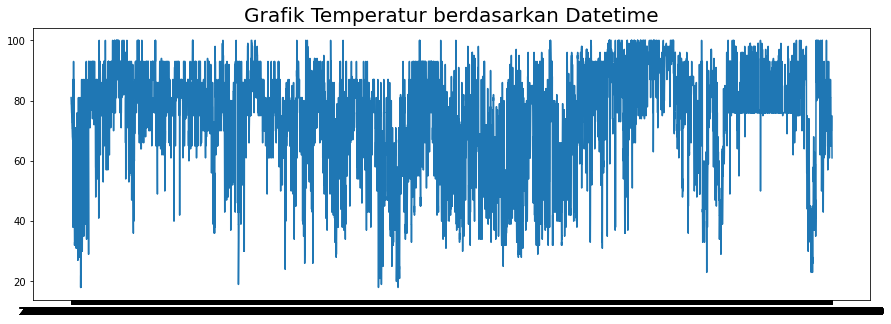

In [9]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Grafik Temperatur berdasarkan Datetime',
          fontsize=20);

**Split data untuk training dan test data**

In [12]:
x_train, x_test, y_train, y_test = train_test_split(temp, dates, train_size=0.8, test_size=0.2, shuffle=False)

**Proses hitung nilai MAE dengan ketentuan MAE < 10% skala data**

In [13]:
nmae = (df['humidity'].max() - df['humidity'].min()) * 10/100
print(nmae)

8.2


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

**Modeling dengan metode Sequential dengan penerapan LSTM**

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Bidirectional(LSTM(60)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [16]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [18]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

**Pendefinisian fungsi callbacks yang membatasi test model ketika mencapai nilai MAE < 10% data skala**

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('mae')<8.2):
        self.model.stop_training = True
        print("\nMAE pada model telah < 10% skala data")

callbacks = myCallback()

In [20]:
tf.keras.backend.set_floatx('float64')

**Proses Training menggunakan model fit dengan epochs 200 menggunakan fungsi callbacks untuk membatasi MAE**

In [21]:
test = model.fit(train_set,
                 epochs=200,
                 validation_data = validation_set,
                 callbacks=[callbacks])

Epoch 1/200
97/97 [==============================] - 25s 199ms/step - loss: 72.4993 - mae: 72.9992 - val_loss: 73.4122 - val_mae: 73.9122
Epoch 2/200
97/97 [==============================] - 17s 176ms/step - loss: 71.1193 - mae: 71.6193 - val_loss: 71.2859 - val_mae: 71.7859
Epoch 3/200
97/97 [==============================] - 17s 176ms/step - loss: 65.7902 - mae: 66.2902 - val_loss: 59.0434 - val_mae: 59.5434
Epoch 4/200
97/97 [==============================] - 17s 177ms/step - loss: 30.5429 - mae: 31.0391 - val_loss: 13.2625 - val_mae: 13.7377
Epoch 5/200
97/97 [==============================] - 17s 176ms/step - loss: 12.5777 - mae: 13.0692 - val_loss: 13.5099 - val_mae: 13.9905
Epoch 6/200
97/97 [==============================] - 17s 177ms/step - loss: 12.5073 - mae: 12.9978 - val_loss: 12.9255 - val_mae: 13.4099
Epoch 7/200
97/97 [==============================] - 17s 177ms/step - loss: 11.9211 - mae: 12.4113 - val_loss: 14.2627 - val_mae: 14.7603
Epoch 8/200
97/97 [===============

**Proses Plotting Loss**

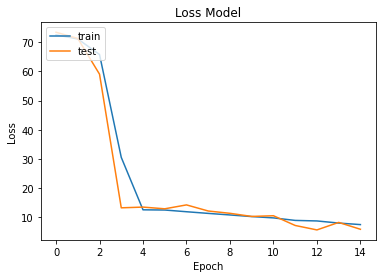

In [22]:
plt.plot(test.history['loss'])
plt.plot(test.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

**Proses Plotting Akurasi Model**

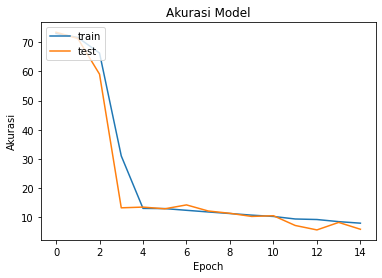

In [23]:
plt.plot(test.history['mae'])
plt.plot(test.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()